<a href="https://colab.research.google.com/github/JaquelineFGomesJardim/Agricultura_Portugal/blob/main/EDA_agricultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA AGRO

# Preparação do ambiente

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q findspark pyspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("EDA_AGRO") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
print("Spark configurado corretamente!")

Spark configurado corretamente!


# Importando as bibliotecas

In [ ]:
import os
import sys
import pytz
import numpy as np
import pandas as pd
import datetime
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, lpad, translate
from datetime import datetime
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, col, to_date, trim, when,sum, min, max,lit,to_timestamp, year, date_format,split, lpad, concat_ws
from pyspark.sql.functions import row_number, countDistinct, expr, sum as _sum, datediff,corr
from pyspark.sql import functions as F
import builtins
import pyspark.sql.types as T
from pyspark.sql.window import Window


# Função de metadados

In [ ]:
def generate_metadata(dataframe):
    # Nome das colunas
    column_names = dataframe.columns

    # Tipo de dados das colunas
    dtypes = [dtype for _, dtype in dataframe.dtypes]

    # Contagem de valores nulos
    null_counts = [dataframe.filter(F.col(c).isNull()).count() for c in column_names]

    # Percentual de valores nulos
    total_count = dataframe.count()
    null_percents = [round((null_count / total_count) * 100, 2) for null_count in null_counts]

    # Cardinalidade (número de valores únicos)
    cardinality = [dataframe.select(c).distinct().count() for c in column_names]

    # Criar um DataFrame PySpark com as informações
    metadata = spark.createDataFrame(
        zip(column_names, dtypes, null_counts, null_percents, cardinality),
        schema=["nome_variavel", "tipo", "qt_nulos", "percent_nulos", "cardinalidade"]
    )

    # Ordenar pelo tipo
    metadata = metadata.orderBy(F.desc("percent_nulos"))

    return metadata


# LEITURA DA BASE YIELD.DF

“Explorando os impactos do clima na produtividade agrícola: uma análise exploratória com dados globais de safras”

In [ ]:
base_dir = "/content/drive/MyDrive/AGRICULTURA"
file_name = "yield_df.csv"
path_input = os.path.join(base_dir, file_name)

df_eda = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv(path_input)
)

df_eda.createOrReplaceTempView("df_eda")
df_eda.cache()
qtd = df_eda.count()
print("Número de colunas em df_eda:", len(df_eda.columns))
print("Número de registros em df_eda:", qtd)

df_eda.show(20, truncate=False)


Número de colunas em df_eda: 8
Número de registros em df_eda: 28242
+---+-------+-----------+----+-----------+-----------------------------+-----------------+--------+
|_c0|Area   |Item       |Year|hg/ha_yield|average_rain_fall_mm_per_year|pesticides_tonnes|avg_temp|
+---+-------+-----------+----+-----------+-----------------------------+-----------------+--------+
|0  |Albania|Maize      |1990|36613      |1485.0                       |121.0            |16.37   |
|1  |Albania|Potatoes   |1990|66667      |1485.0                       |121.0            |16.37   |
|2  |Albania|Rice, paddy|1990|23333      |1485.0                       |121.0            |16.37   |
|3  |Albania|Sorghum    |1990|12500      |1485.0                       |121.0            |16.37   |
|4  |Albania|Soybeans   |1990|7000       |1485.0                       |121.0            |16.37   |
|5  |Albania|Wheat      |1990|30197      |1485.0                       |121.0            |16.37   |
|6  |Albania|Maize      |1991|29

In [ ]:
df_eda.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- hg/ha_yield: integer (nullable = true)
 |-- average_rain_fall_mm_per_year: double (nullable = true)
 |-- pesticides_tonnes: double (nullable = true)
 |-- avg_temp: double (nullable = true)



# METADADOS

In [ ]:
metadata_df = generate_metadata(df_eda)
metadata_df.show(truncate=False)

+-----------------------------+------+--------+-------------+-------------+
|nome_variavel                |tipo  |qt_nulos|percent_nulos|cardinalidade|
+-----------------------------+------+--------+-------------+-------------+
|hg/ha_yield                  |int   |0       |0.0          |11514        |
|_c0                          |int   |0       |0.0          |28242        |
|average_rain_fall_mm_per_year|double|0       |0.0          |100          |
|Area                         |string|0       |0.0          |101          |
|pesticides_tonnes            |double|0       |0.0          |1673         |
|Item                         |string|0       |0.0          |10           |
|avg_temp                     |double|0       |0.0          |1831         |
|Year                         |int   |0       |0.0          |23           |
+-----------------------------+------+--------+-------------+-------------+



In [ ]:
df_eda.describe().show()

+-------+----------------+--------+-------+------------------+-----------------+-----------------------------+------------------+------------------+
|summary|             _c0|    Area|   Item|              Year|      hg/ha_yield|average_rain_fall_mm_per_year| pesticides_tonnes|          avg_temp|
+-------+----------------+--------+-------+------------------+-----------------+-----------------------------+------------------+------------------+
|  count|           28242|   28242|  28242|             28242|            28242|                        28242|             28242|             28242|
|   mean|         14120.5|    NULL|   NULL|2001.5442957297641|77053.33209404434|            1149.055980454642|37076.909343529136|20.542626584519553|
| stddev|8152.90748751634|    NULL|   NULL|7.0519052853951205|84956.61289666739|            709.8121499492227| 59958.78466505776| 6.312050836049751|
|    min|               0| Albania|Cassava|              1990|               50|                         5

## Estatística geral:

Os dados são de 1990 até 2013, ou seja, bem desatualizados para o ano em que estamos, 2025.

Já houve uma produtividade de 50 hg/ha sendo a mínima, e uma maxima de 501412 hg/ha.

Tambem uma média de chuva por ano com um mínimo de 51 mm e uma max de 3240 mm.




In [ ]:
# Produtividade média por item (Produto)

df_eda.groupBy("Item").agg(avg("hg/ha_yield").alias("avg_yield")).orderBy(col("avg_yield").desc()).show()

+--------------------+------------------+
|                Item|         avg_yield|
+--------------------+------------------+
|            Potatoes|199801.54957904585|
|             Cassava|150479.46699266502|
|      Sweet potatoes| 119057.7937716263|
|                Yams|114140.34592680047|
|Plantains and others|106041.32014388489|
|         Rice, paddy| 40730.43476977568|
|               Maize|36310.070613928656|
|               Wheat| 30116.26782473425|
|             Sorghum| 18635.77722935176|
|            Soybeans| 16731.09277071052|
+--------------------+------------------+



## Insight da produtividade média por produto:

A batata lidera o ranking de produção, seguida por mandioca e logo em seguida a bata doce, ou seja, raízes e tubérculos (batata, mandioca, inhame, batata-doce) apresentam rendimentos médios muito superiores em comparação a grãos como soja, milho e etc.





In [35]:
# Produtividade média por área (País)

df_eda.groupBy("Area").agg(avg("hg/ha_yield").alias("avg_yield")).orderBy(col("avg_yield").desc()).show(20, truncate=False)

+--------------+------------------+
|Area          |avg_yield         |
+--------------+------------------+
|United Kingdom|240956.47826086957|
|Belgium       |216468.46153846153|
|Denmark       |214033.02         |
|Netherlands   |204151.20289855072|
|Ireland       |197913.69565217392|
|New Zealand   |191931.8260869565 |
|Sweden        |187405.5          |
|Bahrain       |153237.55172413794|
|Norway        |146115.3260869565 |
|Switzerland   |144960.28260869565|
|Germany       |143631.34444444443|
|Finland       |135014.52173913043|
|Japan         |128851.87577639752|
|Mauritius     |125586.25742574257|
|Jamaica       |122347.86956521739|
|France        |114424.76811594203|
|Egypt         |114375.30434782608|
|Austria       |113044.35416666667|
|Australia     |112951.4099378882 |
|Suriname      |107148.31884057971|
+--------------+------------------+
only showing top 20 rows



## Insight da produtividade média por país:

Top: Reino Unido (240.956 hg/ha), Bélgica (216.468), Dinamarca (214.033).
África e América Latina aparecem em níveis médios/baixos.

Países da Europa do Norte lideram em produtividade, possivelmente pelo uso intensivo de tecnologia, mecanização e práticas agrícolas avançadas.
Diferenças regionais sugerem que infraestrutura e práticas agrícolas importam tanto quanto clima.

In [36]:
# Média da produtividade ao longo dos anos

df_eda.groupBy("Year").agg(avg("hg/ha_yield").alias("avg_yield")).orderBy("Year").show(23)

+----+-----------------+
|Year|        avg_yield|
+----+-----------------+
|1990| 66447.1529209622|
|1991|66318.52061855671|
|1992|66915.77030352748|
|1993|67480.34750613246|
|1994|68516.76576576577|
|1995|  69524.089198036|
|1996|69889.09165302782|
|1997|71160.40522875817|
|1998|71476.46732026144|
|1999|73896.17089125102|
|2000|75376.05203252033|
|2001|76587.04800650936|
|2002|77730.13599348534|
|2004|80590.01944894652|
|2005|80702.02267206478|
|2006|80386.26950925181|
|2007|82532.89452495975|
|2008|84344.38504823152|
|2009|85350.01690821256|
|2010|86512.52610441767|
|2011|88908.33574297189|
|2012| 88569.8507936508|
|2013| 90357.3637807784|
+----+-----------------+



## Insight da produtividade por ano:

 Crescimento consistente de ~66.447 (1990) → ~90.357 (2013).

Tendência de alta quase linear.

A produtividade global vem crescendo ao longo das últimas décadas, provavelmente pela evolução tecnológica (sementes melhoradas, fertilizantes, mecanização).

Esse é um indicador de eficiência do setor agrícola mundial.

A produtividade agrícola global está aumentando, mas nem todos países/culturas se beneficiam igualmente.

In [ ]:
# Relação produtividade x chuva

df_eda.groupBy("average_rain_fall_mm_per_year").agg(avg("hg/ha_yield").alias("avg_yield")).orderBy("average_rain_fall_mm_per_year").show()

+-----------------------------+------------------+
|average_rain_fall_mm_per_year|         avg_yield|
+-----------------------------+------------------+
|                         51.0|114375.30434782608|
|                         56.0| 65335.42028985507|
|                         59.0| 82455.90217391304|
|                         74.0| 86893.13043478261|
|                         83.0|153237.55172413794|
|                         89.0|58872.491228070176|
|                         92.0| 27738.14285714286|
|                        151.0|  76498.9254658385|
|                        207.0| 53974.57971014493|
|                        216.0|39799.717391304344|
|                        241.0| 68545.83333333333|
|                        250.0| 39544.49206349206|
|                        282.0| 72979.32367149758|
|                        285.0| 38603.35365853659|
|                        346.0| 68860.27950310559|
|                        383.0|           18155.2|
|                        416.0|

## Insight correlação produtividade x chuva:

Correlação praticamente nula (0.0009).

Algumas faixas de chuva mostram rendimento altíssimo (83 mm = 153.237), mas não há padrão consistente.

Não existe uma relação linear clara entre chuva média anual e rendimento.
Isso sugere que a chuva isolada não explica produtividade; é necessário cruzar com outras variáveis (solo, temperatura, pesticidas).

* As análises univariadas de clima podem induzir a erro; modelos precisam ser multivariados.

In [ ]:
# Relação produtividade x temperatura

df_eda.groupBy("avg_temp").agg(avg("hg/ha_yield").alias("avg_yield")).orderBy("avg_temp").show()

+--------+------------------+
|avg_temp|         avg_yield|
+--------+------------------+
|     1.3|          148818.5|
|    1.61|           25804.0|
|    1.63|33115.833333333336|
|    1.88|          138289.5|
|     2.5|           47720.5|
|    2.67|           50467.0|
|    2.68|          151808.0|
|    2.72|          150349.0|
|    2.74|          129604.0|
|    2.78|35676.666666666664|
|    2.95|43591.166666666664|
|    3.03|           46643.0|
|    3.06|          157648.0|
|    3.08|          134913.0|
|    3.09|          140769.0|
|    3.12|29346.166666666668|
|    3.23|42614.833333333336|
|    3.25|26978.666666666668|
|    3.31|          137952.5|
|     3.4|          137018.0|
+--------+------------------+
only showing top 20 rows



# Correlações

In [ ]:
# Correlação numérica entre variáveis

num_cols = ["hg/ha_yield", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]
for c in num_cols:
    if c != "hg/ha_yield":
        print(f"Correlação hg/ha_yield x {c}: ", df_eda.stat.corr("hg/ha_yield", c))

Correlação hg/ha_yield x average_rain_fall_mm_per_year:  0.0009621544715997028
Correlação hg/ha_yield x pesticides_tonnes:  0.06408508765267837
Correlação hg/ha_yield x avg_temp:  -0.11477695959121162


In [ ]:
# Top itens mais sensíveis à temperatura

df_eda.groupBy("Item").agg(
    corr("hg/ha_yield", "avg_temp").alias("corr_yield_temp")
).orderBy(col("corr_yield_temp").desc()).show()

+--------------------+--------------------+
|                Item|     corr_yield_temp|
+--------------------+--------------------+
|             Cassava|  0.3540495923468526|
|Plantains and others|-0.06606405116464281|
|            Potatoes|-0.37288342232454075|
|               Wheat|-0.37498281287865765|
|         Rice, paddy| -0.3886866433824704|
|      Sweet potatoes| -0.4066194871366965|
|            Soybeans| -0.4070436277674215|
|             Sorghum| -0.4267321160033323|
|                Yams| -0.5258032639860011|
|               Maize| -0.5452999948606309|
+--------------------+--------------------+



## Insights de relação da produtividade x temperatura e correlação entre as numéricas - Pesticidas x chuva.

Correlação negativa (-0.11).

Plantações como milho, arroz e inhame mostram quedas fortes conforme aumenta a temperatura.

Mandioca é a única que foge à regra (correlação positiva).

De forma geral, temperaturas mais altas reduzem produtividade — exceto para plantações tropicais como mandioca, que se beneficiam de climas quentes.

No contexto do aquecimento global, plantações tropicais podem ganhar competitividade, enquanto cereais sofrem.

In [ ]:
# Top itens mais sensíveis à chuva

df_eda.groupBy("Item").agg(
    corr("hg/ha_yield", "average_rain_fall_mm_per_year").alias("corr_yield_rain")
).orderBy(col("corr_yield_rain").desc()).show()

+--------------------+--------------------+
|                Item|     corr_yield_rain|
+--------------------+--------------------+
|                Yams| 0.20699216243008187|
|Plantains and others| 0.05623591835762768|
|            Soybeans|-0.02557833729692...|
|             Sorghum|-0.02939374929009...|
|               Wheat|  -0.067684905279279|
|            Potatoes|-0.12476091383517537|
|         Rice, paddy|-0.13328128186383145|
|               Maize| -0.1786854730757445|
|             Cassava|-0.19346285220148746|
|      Sweet potatoes| -0.2231879370343967|
+--------------------+--------------------+



## Insght correlação chuva:

Assim como vimos na temperatura, cada cultura responde de forma diferente à chuva: o inhame é mais dependente da precipitação, enquanto mandioca e batata-doce parecem se prejudicar com excesso de água. Isso reforça a ideia de que culturas tropicais têm resiliência a calor, mas não necessariamente a excesso de umidade.

In [ ]:
# Produtividade por item + país (pivot table resumida)

pivot_df = df_eda.groupBy("Area").pivot("Item").agg(avg("hg/ha_yield"))
pivot_df.show(20, truncate=False)

+---------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|Area     |Cassava           |Maize             |Plantains and others|Potatoes          |Rice, paddy       |Sorghum           |Soybeans          |Sweet potatoes    |Wheat             |Yams             |
+---------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|Senegal  |52710.95652173913 |13500.434782608696|NULL                |180499.60869565216|27638.521739130436|8159.173913043478 |NULL              |167172.91304347827|NULL              |NULL             |
|Sweden   |NULL              |NULL              |NULL                |315884.0          |NULL              |NULL              |NULL              |NULL              |58927.0           |NULL

# Insight final:

Cada país tende a ter uma cultura “especialidade”, com rendimentos significativamente maiores.

Europa é fortíssima em batata e trigo; América Latina e África em mandioca e batata-doce.

Potencial para benchmarking agrícola → comparar culturas fortes em cada região e entender práticas que elevam rendimento.

# Vamos analisar Portugal:


In [37]:
# Filtrar apenas registros de Portugal

df_portugal = df_eda.filter(col("Area") == "Portugal")
print("Registros de Portugal:", df_portugal.count())
df_portugal.show(10, truncate=False)

Registros de Portugal: 138
+-----+--------+--------------+----+-----------+-----------------------------+-----------------+--------+
|_c0  |Area    |Item          |Year|hg/ha_yield|average_rain_fall_mm_per_year|pesticides_tonnes|avg_temp|
+-----+--------+--------------+----+-----------+-----------------------------+-----------------+--------+
|23597|Portugal|Maize         |1990|30334      |854.0                        |9357.0           |16.55   |
|23598|Portugal|Potatoes      |1990|111599     |854.0                        |9357.0           |16.55   |
|23599|Portugal|Rice, paddy   |1990|46142      |854.0                        |9357.0           |16.55   |
|23600|Portugal|Sweet potatoes|1990|81250      |854.0                        |9357.0           |16.55   |
|23601|Portugal|Wheat         |1990|14269      |854.0                        |9357.0           |16.55   |
|23602|Portugal|Yams          |1990|104819     |854.0                        |9357.0           |16.55   |
|23603|Portugal|Mai

# METADADOS PORTUGAL:

In [62]:
metadata_df = generate_metadata(df_portugal)
metadata_df.show(truncate=False)

+-----------------------------+------+--------+-------------+-------------+
|nome_variavel                |tipo  |qt_nulos|percent_nulos|cardinalidade|
+-----------------------------+------+--------+-------------+-------------+
|_c0                          |int   |0       |0.0          |138          |
|hg/ha_yield                  |int   |0       |0.0          |138          |
|Area                         |string|0       |0.0          |1            |
|average_rain_fall_mm_per_year|double|0       |0.0          |1            |
|Item                         |string|0       |0.0          |6            |
|pesticides_tonnes            |double|0       |0.0          |22           |
|Year                         |int   |0       |0.0          |23           |
|avg_temp                     |double|0       |0.0          |19           |
+-----------------------------+------+--------+-------------+-------------+



## Observações:

Com o metadados confirmo que temos registros em todos os anos do df para Portugal, 23 no total.

Temos 6 itens (produtos) com iformações.

22 tipos de pesticidas, 19 médias de temperaturas diferentes.

138 registros diferentes para 138 linhas.Já está na granularidade 1:1.

In [38]:
df_portugal.createOrReplaceTempView("df_portugal")
df_portugal.describe().show()

+-------+-----------------+--------+-----+------------------+------------------+-----------------------------+------------------+------------------+
|summary|              _c0|    Area| Item|              Year|       hg/ha_yield|average_rain_fall_mm_per_year| pesticides_tonnes|          avg_temp|
+-------+-----------------+--------+-----+------------------+------------------+-----------------------------+------------------+------------------+
|  count|              138|     138|  138|               138|               138|                          138|               138|               138|
|   mean|          23665.5|    NULL| NULL|2001.4347826086957| 88074.97826086957|                        854.0|13293.815652173904|16.376956521739114|
| stddev|39.98124560340761|    NULL| NULL| 7.089579606965067|55931.539883018195|                          0.0| 3082.196111907602|0.4180186296544438|
|    min|            23597|Portugal|Maize|              1990|              6644|                        85

### Estatistica basica Portugal:

Temos dados com ano minimo 1990 e max 2013.

A informação de chuva por ano tem cardinalidade 1 (como podemos ver no metadados), indica ser uma limitação do dado.

Produtividade temos um min e max com bastante diferença e uma média de ~88 mil, poém, com um desvio padrão de ~55.931 mostrando alta variabilidade entre culturas/anos.

Utilização de pesticidas com média ~13.3mil.

Temperatura média de ~16.3 com baixa variação, típico do mediterrâneo.


# Resumo:

Portugal apresenta forte oscilação de produtividade agrícola, o que sugere que fatores além de chuva/temperatura (práticas agrícolas, insumos, mecanização, tipo de item) influenciam fortemente o rendimento.

# Cobertura de dados por ano:

In [41]:
df_portugal.groupBy("Year").count().orderBy("Year").show(23)

+----+-----+
|Year|count|
+----+-----+
|1990|    6|
|1991|    6|
|1992|    6|
|1993|    6|
|1994|    6|
|1995|    6|
|1996|    6|
|1997|    6|
|1998|    6|
|1999|    6|
|2000|    6|
|2001|    6|
|2002|    6|
|2004|    6|
|2005|    6|
|2006|    6|
|2007|    6|
|2008|    6|
|2009|    6|
|2010|    6|
|2011|    6|
|2012|    6|
|2013|    6|
+----+-----+



## Temos a mesma quantidade de registros para todos os anos, um registro para cada item que são 6 no total.

In [40]:
df_portugal.groupBy("Item").avg("hg/ha_yield").orderBy("avg(hg/ha_yield)", ascending=False).show()

+--------------+------------------+
|          Item|  avg(hg/ha_yield)|
+--------------+------------------+
|      Potatoes|150131.69565217392|
|          Yams|139049.47826086957|
|Sweet potatoes|112087.04347826086|
|   Rice, paddy| 56913.86956521739|
|         Maize|54824.782608695656|
|         Wheat|           15443.0|
+--------------+------------------+



## Item que mais produziu em Portugal:

Vimos aqui que a batata foi o item que Portugal mais produziu nesses 23 anos do dataset.

Vamos entrar mais na granularidade dos anos.


## Quantidade da produtividade de cada produto por ano:

In [42]:
df_portugal.groupBy("Year", "Item").avg("hg/ha_yield").orderBy("Year").show()

+----+--------------+----------------+
|Year|          Item|avg(hg/ha_yield)|
+----+--------------+----------------+
|1990|         Wheat|         14269.0|
|1990|         Maize|         30334.0|
|1990|          Yams|        104819.0|
|1990|      Potatoes|        111599.0|
|1990|   Rice, paddy|         46142.0|
|1990|Sweet potatoes|         81250.0|
|1991|          Yams|         77020.0|
|1991|Sweet potatoes|         77143.0|
|1991|         Wheat|         20982.0|
|1991|   Rice, paddy|         50940.0|
|1991|      Potatoes|        126513.0|
|1991|         Maize|         30411.0|
|1992|      Potatoes|        143260.0|
|1992|   Rice, paddy|         51948.0|
|1992|Sweet potatoes|         90000.0|
|1992|          Yams|         81455.0|
|1992|         Wheat|         12914.0|
|1992|         Maize|         34547.0|
|1993|         Wheat|         16861.0|
|1993|          Yams|        102035.0|
+----+--------------+----------------+
only showing top 20 rows



## Ranking de produção ordenado por ano e item:

In [43]:
(df_portugal
 .groupBy("Year","Item")
 .avg("hg/ha_yield").withColumnRenamed("avg(hg/ha_yield)", "avg_yield_hg_ha")
 .orderBy(col("Year").asc(), col("avg_yield_hg_ha").desc())
 .show(50, truncate=False))

+----+--------------+---------------+
|Year|Item          |avg_yield_hg_ha|
+----+--------------+---------------+
|1990|Potatoes      |111599.0       |
|1990|Yams          |104819.0       |
|1990|Sweet potatoes|81250.0        |
|1990|Rice, paddy   |46142.0        |
|1990|Maize         |30334.0        |
|1990|Wheat         |14269.0        |
|1991|Potatoes      |126513.0       |
|1991|Sweet potatoes|77143.0        |
|1991|Yams          |77020.0        |
|1991|Rice, paddy   |50940.0        |
|1991|Maize         |30411.0        |
|1991|Wheat         |20982.0        |
|1992|Potatoes      |143260.0       |
|1992|Sweet potatoes|90000.0        |
|1992|Yams          |81455.0        |
|1992|Rice, paddy   |51948.0        |
|1992|Maize         |34547.0        |
|1992|Wheat         |12914.0        |
|1993|Potatoes      |139420.0       |
|1993|Yams          |102035.0       |
|1993|Sweet potatoes|91427.0        |
|1993|Rice, paddy   |52273.0        |
|1993|Maize         |37231.0        |
|1993|Wheat 

## Item lider de produtividade por ano :

In [45]:
from pyspark.sql.functions import desc

w = Window.partitionBy("Year").orderBy(desc("avg_yield_hg_ha"))

top_item_por_ano = (
    df_portugal.groupBy("Year","Item")
    .avg("hg/ha_yield").withColumnRenamed("avg(hg/ha_yield)", "avg_yield_hg_ha")
    .withColumn("rk", row_number().over(w))
    .filter(col("rk")==1)
    .orderBy("Year")
)

top_item_por_ano.show(30, truncate=False)


+----+--------------+---------------+---+
|Year|Item          |avg_yield_hg_ha|rk |
+----+--------------+---------------+---+
|1990|Potatoes      |111599.0       |1  |
|1991|Potatoes      |126513.0       |1  |
|1992|Potatoes      |143260.0       |1  |
|1993|Potatoes      |139420.0       |1  |
|1994|Potatoes      |144950.0       |1  |
|1995|Potatoes      |148462.0       |1  |
|1996|Potatoes      |145807.0       |1  |
|1997|Yams          |167258.0       |1  |
|1998|Yams          |161538.0       |1  |
|1999|Potatoes      |156482.0       |1  |
|2000|Yams          |149690.0       |1  |
|2001|Potatoes      |149725.0       |1  |
|2002|Potatoes      |161642.0       |1  |
|2004|Potatoes      |169935.0       |1  |
|2005|Yams          |156771.0       |1  |
|2006|Yams          |166667.0       |1  |
|2007|Potatoes      |167685.0       |1  |
|2008|Yams          |163636.0       |1  |
|2009|Potatoes      |164431.0       |1  |
|2010|Sweet potatoes|183175.0       |1  |
|2011|Sweet potatoes|253007.0     

## Insight:

A batata lidera a maior produtividade em Portugal por 13 anos, seguida do inhame com 6 anos no topo e depois a batata doce.

# Gráfico da produtividade dos itens por ano:

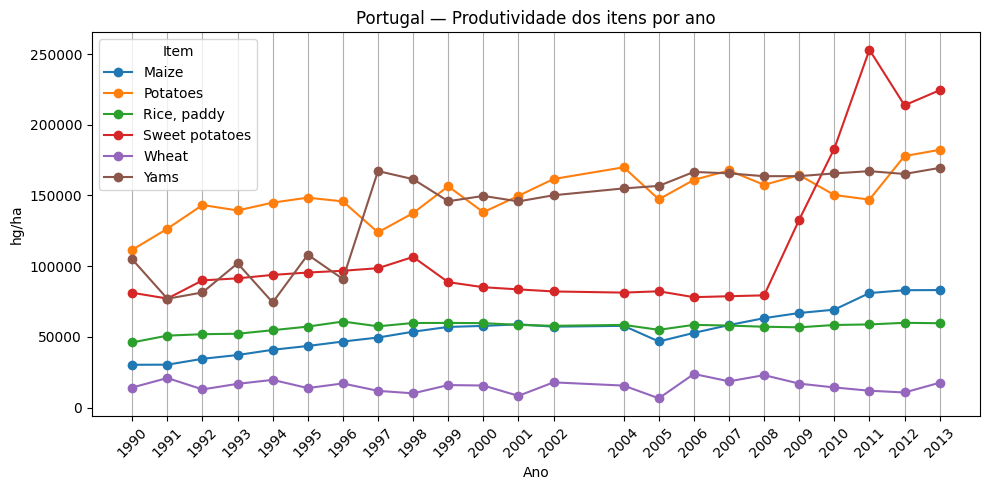

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

df_item_ano = (df_portugal.groupBy("Year","Item")
               .avg("hg/ha_yield").withColumnRenamed("avg(hg/ha_yield)", "avg_yield_hg_ha"))
pdf = df_item_ano.toPandas()

# pivot para linhas por Item
pivot = pdf.pivot(index="Year", columns="Item", values="avg_yield_hg_ha").sort_index()

ax = pivot.plot(figsize=(10,5), marker="o")
ax.set_title("Portugal — Produtividade dos itens por ano")
ax.set_ylabel("hg/ha")
ax.set_xlabel("Ano")

years = sorted(pivot.index.tolist())
ax.set_xticks(years)
ax.set_xticklabels([str(y) for y in years], rotation=45)
ax.grid(True, axis="x")

plt.tight_layout()

## Observações:


De partida, que chama a atenção é a produtividade de inhame, que em 1997 teve uma alta e manteve uma certa constancia até o ultimo ano do dataset.

Posteriormente a batata doce, que teve uma subida exponencial em 2010 ultrapassando todos os outros itens, e se manteve com maior produtividade pelos 4 anos finais do df, ainda que com oscilação entre 2011-2013.

Isso pode indicar: Mudança de estrategia na agricultura portuguesa, com estudos de aproveitamento de solo, pesquisa de mercado, adoção de variedades/manejo, mecanização ou mudança de medição/fonte e etc.

Esse gráfico confirma o que vimos no quadro anterior.



# Grafico da distribuição por item :

Text(0.5, 0, 'Item')

<Figure size 800x300 with 0 Axes>

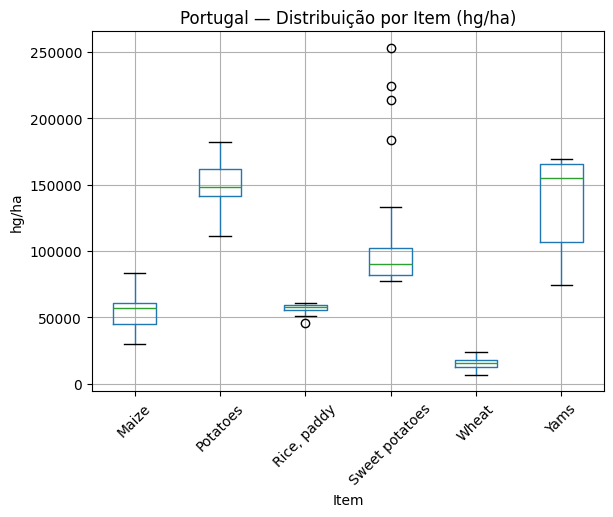

In [80]:
pdf_box = pdf[["Item","avg_yield_hg_ha"]].dropna()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
pdf_box.boxplot(by="Item", column="avg_yield_hg_ha", rot=45)
plt.title("Portugal — Distribuição por Item (hg/ha)")
plt.suptitle("")
plt.ylabel("hg/ha")
plt.xlabel("Item")


## Observações:

Mesmo com outros produtos tendo uma alta na produtividade, a batata tem uma concentração produtiva mais alta e relativamente estável, no total, o que confirma sua posição como um dos itens mais eficientes em Portugal, com mediana nos ~150 mil.

Podemos ver também os outliers para batata doce acima dos ~200 mil,porém a mediana geral ficou em torno de ~90 mil.

O inhame apesar da distribuição ser entre ~100 mil e ~170 mil, a mediana fica em torno de ~150,5 mil, o que sugere estabilidade de alto nível, reforçando o salto que vimos em 1997.

A produtividade mais baixa e de menor concentração é do trigo, mostrando vulnerabilidade e possível menor competitividade frente os demais.

# Gráfico do item com melhor produtividade por ano:

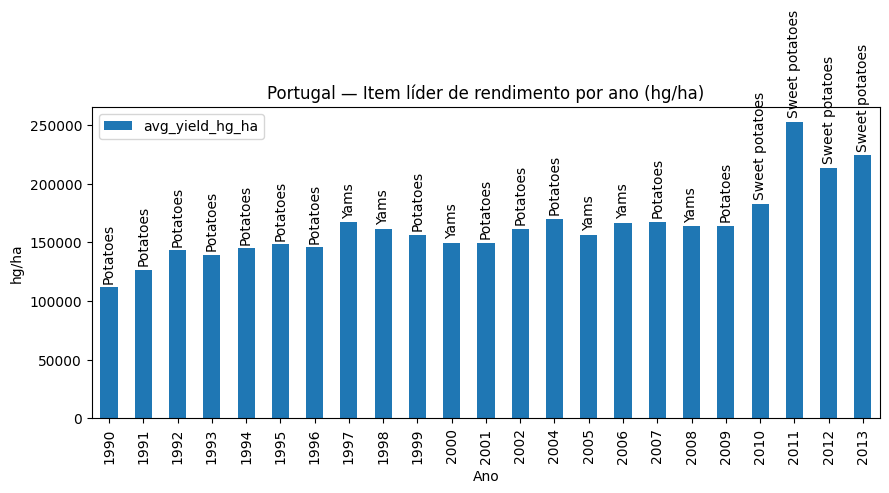

In [84]:
pdf_top = top_item_por_ano.toPandas()

ax = pdf_top.plot(kind="bar", x="Year", y="avg_yield_hg_ha", figsize=(9,5))
ax.set_title("Portugal — Item líder de rendimento por ano (hg/ha)")
ax.set_ylabel("hg/ha")
ax.set_xlabel("Ano")

for p, item in zip(ax.patches, pdf_top["Item"]):
    height = p.get_height()
    ax.annotate(
        item,
        (p.get_x() + p.get_width()/2, height),
        ha="center", va="bottom",
        rotation=90,
        xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()

In [63]:
from pyspark.sql import functions as F

inicio = (df_portugal.groupBy("Item")
          .agg(F.first(F.struct("Year","hg/ha_yield")).alias("first"))
          .select(
              F.col("Item"),
              F.col("first.Year").alias("ano_ini"),
              F.col("first.hg/ha_yield").alias("yield_ini_hg_ha")
          ))

fim = (df_portugal.orderBy(F.col("Year").desc())
       .groupBy("Item")
       .agg(F.first(F.struct("Year","hg/ha_yield")).alias("last"))
       .select(
           F.col("Item"),
           F.col("last.Year").alias("ano_fim"),
           F.col("last.hg/ha_yield").alias("yield_fim_hg_ha")
       ))

evol = (inicio.join(fim, "Item")
        .withColumn("var_abs_hg_ha", F.col("yield_fim_hg_ha")-F.col("yield_ini_hg_ha"))
        .withColumn("var_pct", F.when(F.col("yield_ini_hg_ha")>0,
                                      (F.col("yield_fim_hg_ha")/F.col("yield_ini_hg_ha")-1)*100)
                             .otherwise(F.lit(None)))
        .orderBy(F.col("var_pct").desc()))

evol.show(truncate=False)

+--------------+-------+---------------+-------+---------------+-------------+------------------+
|Item          |ano_ini|yield_ini_hg_ha|ano_fim|yield_fim_hg_ha|var_abs_hg_ha|var_pct           |
+--------------+-------+---------------+-------+---------------+-------------+------------------+
|Sweet potatoes|1990   |81250          |2013   |224367         |143117       |176.14399999999998|
|Maize         |1990   |30334          |2013   |83149          |52815        |174.11155798773655|
|Potatoes      |1990   |111599         |2013   |182243         |70644        |63.30164248783592 |
|Yams          |1990   |104819         |2013   |169492         |64673        |61.69969184976005 |
|Rice, paddy   |1990   |46142          |2013   |59699          |13557        |29.38104113389104 |
|Wheat         |1990   |14269          |2013   |17635          |3366         |23.58959983180322 |
+--------------+-------+---------------+-------+---------------+-------------+------------------+



# Grafico de crescimento (%) dos itens:

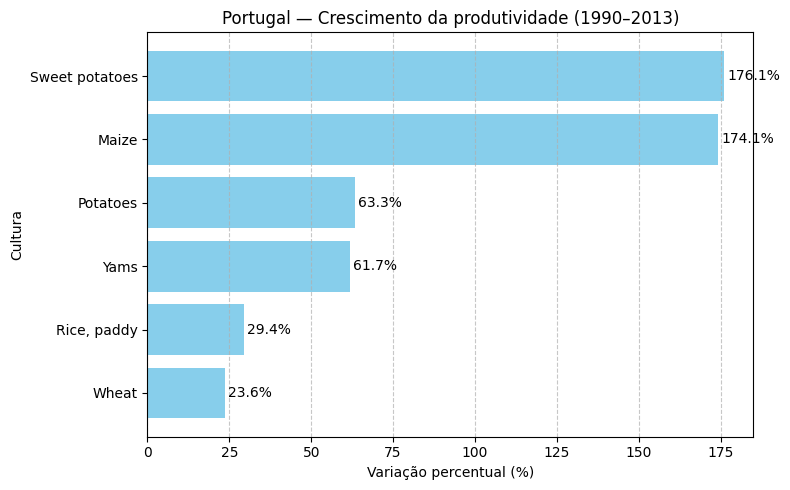

In [86]:
pdf_evol = evol.toPandas()

pdf_evol = pdf_evol.sort_values("var_pct", ascending=True)

plt.figure(figsize=(8,5))
bars = plt.barh(pdf_evol["Item"], pdf_evol["var_pct"], color="skyblue")

for bar, pct in zip(bars, pdf_evol["var_pct"]):
    plt.text(bar.get_width()+1, bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", va="center")

plt.title("Portugal — Crescimento da produtividade (1990–2013)")
plt.xlabel("Variação percentual (%)")
plt.ylabel("Cultura")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Observações:

O gráfico evidencia que a batata-doce (+176%) e o milho (+174%) foram as culturas que mais aceleraram sua produtividade em Portugal entre 1990 e 2013.
A batata (+63%) e o inhame (+61%) tiveram avanços relevantes, mas em menor escala.
Já o arroz (+29%) e, principalmente, o trigo (+23%), mostraram crescimento modesto, ficando para trás em competitividade.

# Gráfico de crescimento absoluto:

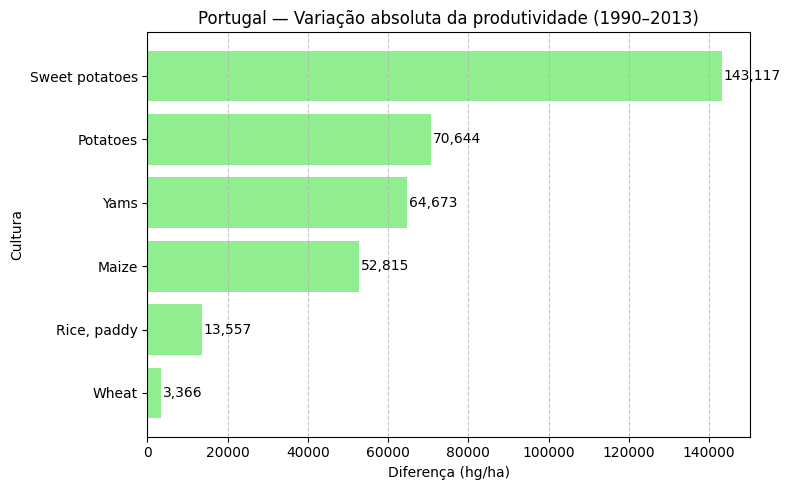

In [87]:
# Ordenar pelo valor absoluto
pdf_evol_abs = pdf_evol.sort_values("var_abs_hg_ha", ascending=True)

plt.figure(figsize=(8,5))
bars = plt.barh(pdf_evol_abs["Item"], pdf_evol_abs["var_abs_hg_ha"], color="lightgreen")

for bar, val in zip(bars, pdf_evol_abs["var_abs_hg_ha"]):
    plt.text(bar.get_width()+500, bar.get_y() + bar.get_height()/2,
             f"{val:,.0f}", va="center")

plt.title("Portugal — Variação absoluta da produtividade (1990–2013)")
plt.xlabel("Diferença (hg/ha)")
plt.ylabel("Cultura")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Observações:

Batata-doce: lidera tanto em percentual (+176%) quanto em ganho absoluto (+143.117 hg/ha), indicando uma mudança estrutural na cultura.

Batata: mesmo sem o maior percentual (+63%), apresentou +70.644 hg/ha de ganho absoluto, ficando atrás apenas da batata-doce — reforça sua posição como cultura estável e de alta relevância.

Milho: mostrou crescimento expressivo em percentual (+174%), mas com ganho absoluto menor que o da batata — revela eficiência relativa alta, mas com impacto real menos significativo.

Trigo e arroz: aparecem no fundo de ambos os rankings, com ganhos modestos (+23% e +29%), confirmando que são itens pouco competitivos em Portugal no período analisado.

Ou seja, olhar apenas para os percentuais pode induzir a uma falsa percepção de impacto. A análise combinada mostra que nem sempre quem cresce mais em termos relativos é quem gera maior ganho absoluto de produtividade.

# Grafico comparativo:

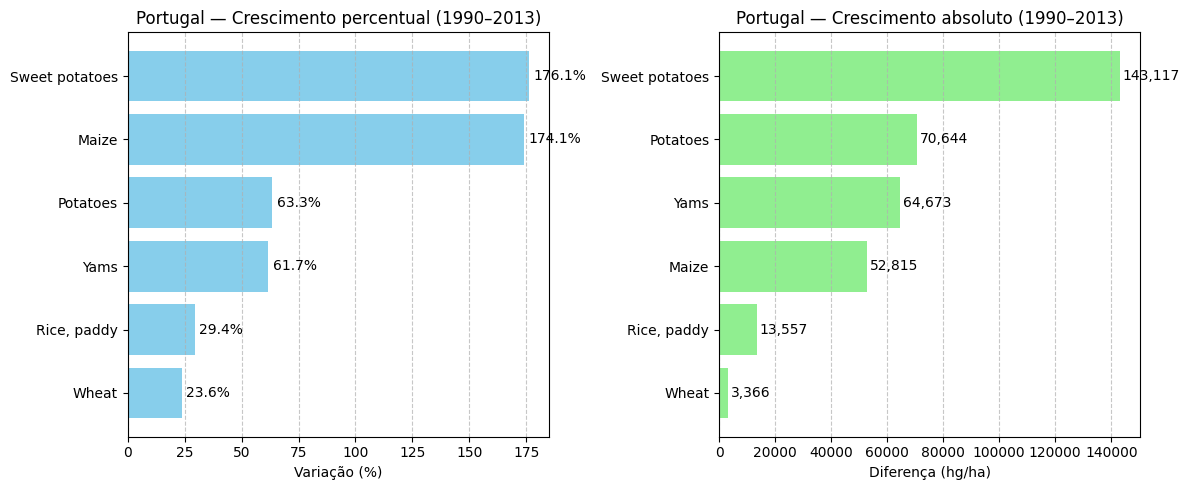

In [89]:
pdf_evol_pct = pdf_evol.sort_values("var_pct", ascending=True)
pdf_evol_abs = pdf_evol.sort_values("var_abs_hg_ha", ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Gráfico 1: Percentual (%)
bars1 = axes[0].barh(pdf_evol_pct["Item"], pdf_evol_pct["var_pct"], color="skyblue")
axes[0].set_title("Portugal — Crescimento percentual (1990–2013)")
axes[0].set_xlabel("Variação (%)")
axes[0].grid(axis="x", linestyle="--", alpha=0.7)

for bar, pct in zip(bars1, pdf_evol_pct["var_pct"]):
    axes[0].text(bar.get_width()+2, bar.get_y() + bar.get_height()/2,
                 f"{pct:.1f}%", va="center")

# Gráfico 2: Absoluto (hg/ha)
bars2 = axes[1].barh(pdf_evol_abs["Item"], pdf_evol_abs["var_abs_hg_ha"], color="lightgreen")
axes[1].set_title("Portugal — Crescimento absoluto (1990–2013)")
axes[1].set_xlabel("Diferença (hg/ha)")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

for bar, val in zip(bars2, pdf_evol_abs["var_abs_hg_ha"]):
    axes[1].text(bar.get_width()+1000, bar.get_y() + bar.get_height()/2,
                 f"{val:,.0f}", va="center")

plt.tight_layout()
plt.show()


## Observações finais:

O gráfico combinado evidencia que a interpretação da evolução agrícola precisa considerar tanto o percentual quanto o ganho absoluto. Culturas como milho podem parecer líderes quando olhamos apenas para %, mas em termos de impacto real, batata e inhame tiveram maior contribuição.

Conclusão: a batata-doce é a grande protagonista da transformação, enquanto arroz e trigo seguem como pontos fracos da produtividade em Portugal.